In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\aksha\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [17]:
# Initiliazing the sequential model
def best_hyperparameters(units):

    model = Sequential()
    # Configuring the parameters
    model.add(LSTM(units, input_shape=(timesteps, input_dim)))
    # Adding a dropout layer
    model.add(Dropout(0.5))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid',kernel_initializer="glorot_normal"))
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    return model

In [18]:
units = [16,32,64,128,256]

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=best_hyperparameters, epochs=epochs, batch_size=batch_size, verbose=0)
param_grid = dict(units=units)

# if you are using CPU
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# if you are using GPU dont use the n_jobs parameter

grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3)
grid_result = grid.fit(X_train, Y_train)

In [42]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.917437 using {'units': 256}


In [19]:
model_2 = Sequential()
    # Configuring the parameters
model_2.add(LSTM(256,return_sequences=True, input_shape=(timesteps, input_dim)))

model_2.add(LSTM(256, input_shape=(timesteps, input_dim)))
    # Adding a dropout layer
model_2.add(Dropout(0.3))
    # Adding a dense output layer with sigmoid activation
model_2.add(Dense(n_classes, activation='sigmoid',kernel_initializer="glorot_normal"))
model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model_2.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 256)          272384    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 799,238
Trainable params: 799,238
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# Training the model
history=model_2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 221s 30ms/step - loss: 0.3005 - acc: 0.8714 - val_loss: 0.2540 - val_acc: 0.8778
Epoch 2/30
7352/7352 [==============================] - 203s 28ms/step - loss: 0.2308 - acc: 0.8902 - val_loss: 0.2227 - val_acc: 0.8949
Epoch 3/30
7352/7352 [==============================] - 195s 27ms/step - loss: 0.1488 - acc: 0.9391 - val_loss: 0.0953 - val_acc: 0.9628
Epoch 4/30
7352/7352 [==============================] - 227s 31ms/step - loss: 0.0749 - acc: 0.9732 - val_loss: 0.0924 - val_acc: 0.9641
Epoch 5/30
7352/7352 [==============================] - 218s 30ms/step - loss: 0.0753 - acc: 0.9737 - val_loss: 0.1349 - val_acc: 0.9571
Epoch 6/30
7352/7352 [==============================] - 224s 30ms/step - loss: 0.0565 - acc: 0.9798 - val_loss: 0.1462 - val_acc: 0.9498
Epoch 7/30
7352/7352 [==============================] - 224s 31ms/step - loss: 0.0

In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_2.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      420        70        0                   0   
STANDING                 0      147       384        1                   0   
WALKING                  0        6         0      454                  19   
WALKING_DOWNSTAIRS       0        1         0        2                 405   
WALKING_UPSTAIRS         0        2         0        2                   3   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                           17  
WALKING_DOWNSTAIRS                12  
WALKING_UPSTAIRS                 464  


In [24]:
score = model_2.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']


Test score: 0.1250544917161217
Test accuracy: 0.968385927467618


In [27]:
import matplotlib.pyplot as plt
def plot(x,ty,vy):
    plt.xlabel("epochs")
    plt.ylabel("cross entropy error")
    plt.plot(x,vy,'b', label="Validation Loss")
    plt.plot(x,ty,'r', label="Train Loss")
    plt.legend()
    plt.show()

  

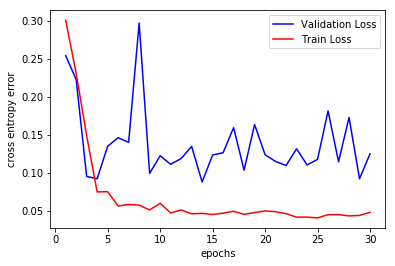

In [31]:
plot(x,ty,vy)

In [32]:
score

[0.1250544917161217, 0.968385927467618]

the optimal units were 256